# Moving Averages CINGULATE region

### 1) Imports

In [1]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from datasets import SkeletonDataset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [3]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [4]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"

In [6]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/gridsearch/n_2_kl_2/'
model = VAE((1, 20, 40, 40), 2, depth=3)
model.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model = model.to(device)

In [7]:
subject_dir = "/neurospin/dico/data/deep_folding/current/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/"

train_list = pd.read_csv(os.path.join(subject_dir,
                         f"HCP_half_{1}bis.csv"), header=None,
                         usecols=[0], names=['subjects'])

train_list['subjects'] = train_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(train_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(train_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames)

In [8]:
dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=64,
              num_workers=8,
              shuffle=True)    

In [9]:
dico_set_loaders = {'data': dataloader}

root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/n_2_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=2, depth=3, root_dir=root_dir)

In [10]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['data']
X = np.array(list(df_encoded['latent']))
labels = list(results['data'].keys())

0.40201262
For n_clusters = 2 The average silhouette_score with kmeans is : 0.40201262


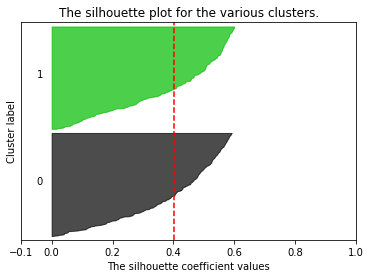

0.33849394
For n_clusters = 3 The average silhouette_score with kmeans is : 0.33849394


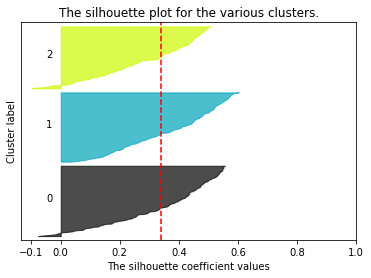

0.36225465
For n_clusters = 4 The average silhouette_score with kmeans is : 0.36225465


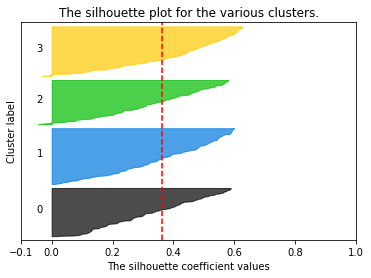

0.35490283
For n_clusters = 5 The average silhouette_score with kmeans is : 0.35490283


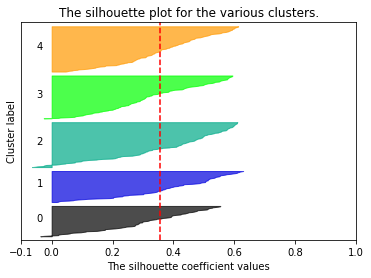

0.3522443
For n_clusters = 6 The average silhouette_score with kmeans is : 0.3522443


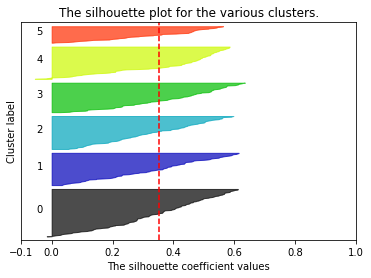

0.34155804
For n_clusters = 7 The average silhouette_score with kmeans is : 0.34155804


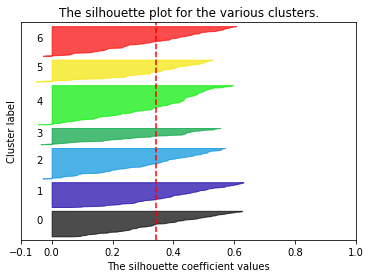

0.33563283
For n_clusters = 8 The average silhouette_score with kmeans is : 0.33563283


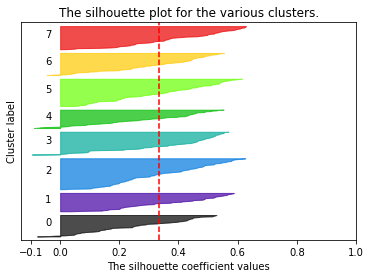

0.3552464
For n_clusters = 9 The average silhouette_score with kmeans is : 0.3552464


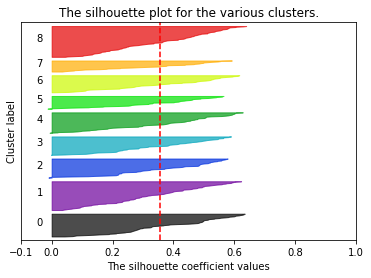

0.34868455
For n_clusters = 10 The average silhouette_score with kmeans is : 0.34868455


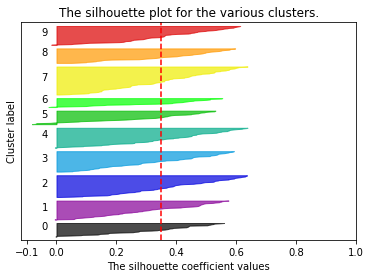

In [11]:
n_clusters_list = [2, 3, 4,5,6,7,8,9,10]

for n in n_clusters_list:
    cluster_labels= KMeans(n_clusters=n, random_state=0).fit_predict(X)
    print(str(metrics.silhouette_score(X, cluster_labels)))

    fig, ax1 = plt.subplots()
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score with kmeans is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

The best silhouette score is obtained with n_clusters = 2

In [12]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
cluster_labels = kmeans.labels_
clusters_centroids = kmeans.cluster_centers_
print(f"Average silhouette score: {metrics.silhouette_score(X, cluster_labels)}")


Average silhouette score: 0.4020126163959503


In [13]:
dstrb_sub = pd.DataFrame(X, index=labels, columns=[1, 2])
dstrb_sub['cluster_lab'] = cluster_labels

In [14]:
dstrb_sub.head()

,1,2,cluster_lab
392447,-2.270086,0.346315,0
159138,-2.549594,0.905099,0
152427,-0.617023,3.005473,1
825654,-1.167892,1.413008,1
573249,-3.051331,2.409786,0


In [15]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[-2.3053873  1.0942559]
 [-0.9350174  2.3462682]]


In [16]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

Closest subject to centroid of cluster 1 is 121315
Closest subject to centroid of cluster 2 is 552544


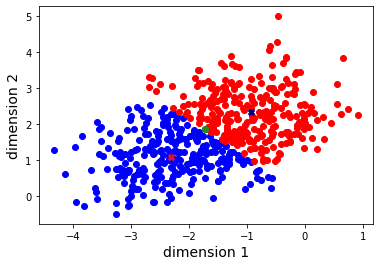

In [17]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])

color_dict = {1: 'red', 0:'blue'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(dstrb_sub[1]['208125'], dstrb_sub[2]['208125'], color='forestgreen')
#ax.scatter(dstrb_sub[1]['133827'], dstrb_sub[2]['133827'], color='forestgreen')

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 2', fontsize=14)
plt.show()

In [18]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)

### Creation of buckets dictionnary

In [19]:
def create_bucket(vol):
    arr = np.asarray(vol)

    # Threshold and "binarize"
    arr[np.where(arr > 1)]=1
    # Writes volume
    temp_dir = '/tmp/'
    threshold_filename = f'{temp_dir}/temp_threshold.nii.gz'
    aims.write(vol, threshold_filename)
    # Save to bucket file
    bucket_filename = f"{temp_dir}/temp_bucket.bck"
    cmd = f"AimsFileConvert -c Bucket -t VOID -e 1 -i {threshold_filename} -o {bucket_filename}"
    os.system(cmd)
    # Displays bucket file
    bucket, bucket_raw, dxyz, rot, tr = ma.load_bucket(bucket_filename)
    m = dtx.convert.bucket_to_mesh(bucket)
    cmd = f"rm {threshold_filename} {threshold_filename+'.minf'} {bucket_filename} {bucket_filename+'.minf'}"
    os.system(cmd)
    
    return bucket, m

In [20]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'
suffix_path = '_normalized.nii.gz'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket, m = create_bucket(bucket)
    bucket = np.asarray(bucket)
    buckets[sub] = bucket

  9%|▉         | 49/550 [01:10<12:03,  1.44s/it]


SystemError: <built-in method doit of Mesher object at 0x7f1f03eb3048> returned a result with an error set

In [37]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    #bucket, m = create_bucket(bucket)
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

  0%|          | 2/550 [00:00<00:32, 16.62it/s]

392447
159138
152427
825654


  1%|          | 6/550 [00:00<00:39, 13.93it/s]

573249
199150
211922


  1%|▏         | 8/550 [00:00<00:40, 13.27it/s]

891667
102513
189450


  2%|▏         | 12/550 [00:00<00:36, 14.58it/s]

179245
176441
510326
152225


  3%|▎         | 16/550 [00:01<00:33, 15.83it/s]

204218
199251
445543
889579


  4%|▎         | 20/550 [00:01<00:33, 15.89it/s]

105620
153025
119126
381038


  4%|▍         | 24/550 [00:01<00:32, 16.11it/s]

186444
894774
118124
111312


  5%|▌         | 28/550 [00:01<00:37, 13.90it/s]

173839
213522
157942


  5%|▌         | 30/550 [00:02<00:47, 10.87it/s]

910241
108525


  6%|▌         | 32/550 [00:02<01:00,  8.58it/s]

191336
365343
878877


  6%|▌         | 34/550 [00:03<01:21,  6.32it/s]

214524


  6%|▋         | 35/550 [00:03<01:45,  4.89it/s]

530635


  7%|▋         | 38/550 [00:03<01:32,  5.52it/s]

100307
168745
203721


  7%|▋         | 40/550 [00:04<01:33,  5.44it/s]

145834
154734


  8%|▊         | 42/550 [00:04<01:15,  6.74it/s]

165436
102614
300618


  8%|▊         | 46/550 [00:04<01:00,  8.27it/s]

144226
360030
141119


  9%|▊         | 48/550 [00:05<01:04,  7.76it/s]

193845
177342


  9%|▉         | 51/550 [00:05<00:56,  8.90it/s]

361941
148335
517239


 10%|▉         | 53/550 [00:05<00:50,  9.85it/s]

385046
154431
318637


 10%|█         | 57/550 [00:06<00:48, 10.07it/s]

705341
198653
167440


 11%|█         | 59/550 [00:06<00:48, 10.10it/s]

108222
160931
146432


 11%|█▏        | 63/550 [00:06<00:42, 11.53it/s]

561242
510225
353740


 12%|█▏        | 67/550 [00:06<00:39, 12.24it/s]

194645
849971
124220


 13%|█▎        | 69/550 [00:07<00:38, 12.49it/s]

142424
987074
303624
164030


 13%|█▎        | 73/550 [00:07<00:39, 12.14it/s]

571144
919966
188145
973770


 14%|█▎        | 75/550 [00:07<00:49,  9.66it/s]

100610
166640


 14%|█▍        | 77/550 [00:07<00:49,  9.59it/s]

169545


 14%|█▍        | 79/550 [00:08<00:55,  8.54it/s]

204622
389357
951457


 15%|█▌        | 83/550 [00:08<00:46,  9.97it/s]

188448
182840
160830
953764


 15%|█▌        | 85/550 [00:08<00:43, 10.71it/s]

159239
168947


 16%|█▌        | 87/550 [00:09<00:51,  8.99it/s]

164939
339847


 16%|█▋        | 90/550 [00:09<00:59,  7.77it/s]

634748
210011


 17%|█▋        | 92/550 [00:09<01:05,  6.94it/s]

414229
170631


 17%|█▋        | 93/550 [00:09<01:08,  6.64it/s]

894067


 17%|█▋        | 95/550 [00:10<01:13,  6.15it/s]

103111
139637


 18%|█▊        | 98/550 [00:10<00:56,  8.03it/s]

174437
133019
677766


 18%|█▊        | 100/550 [00:10<00:46,  9.62it/s]

208630
209228


 19%|█▊        | 102/550 [00:11<00:48,  9.26it/s]

197449
286347
586460


 19%|█▉        | 106/550 [00:11<00:41, 10.71it/s]

115320
169949
959574


 20%|█▉        | 108/550 [00:11<00:40, 11.01it/s]

792867
162733
138231


 20%|██        | 110/550 [00:11<00:41, 10.48it/s]

239944
185038


 21%|██        | 113/550 [00:12<00:47,  9.11it/s]

136732
173233


 21%|██        | 115/550 [00:12<00:50,  8.54it/s]

316835
136126


 21%|██▏       | 118/550 [00:12<00:46,  9.22it/s]

529953
180533
178950


 22%|██▏       | 120/550 [00:13<00:53,  7.96it/s]

128632
131621


 22%|██▏       | 122/550 [00:13<00:52,  8.15it/s]

597869
114318


 23%|██▎       | 124/550 [00:13<01:07,  6.35it/s]

463040
194847


 23%|██▎       | 127/550 [00:13<00:51,  8.23it/s]

159946
118225
137936


 24%|██▍       | 131/550 [00:14<00:35, 11.91it/s]

144731
198047
208226
352132


 25%|██▍       | 135/550 [00:14<00:30, 13.70it/s]

201818
580751
173738
131722


 25%|██▌       | 139/550 [00:14<00:27, 14.96it/s]

129129
993675
192439
126325


 26%|██▌       | 143/550 [00:14<00:26, 15.18it/s]

175136
336841
880157
436845


 26%|██▋       | 145/550 [00:15<00:30, 13.16it/s]

138837
169747


 27%|██▋       | 147/550 [00:15<00:42,  9.56it/s]

562345
901442
227533


 27%|██▋       | 151/550 [00:16<00:46,  8.55it/s]

136227
140117
767464
387959


 28%|██▊       | 155/550 [00:16<00:36, 10.87it/s]

584355
113215
901139


 29%|██▉       | 159/550 [00:16<00:30, 12.65it/s]

480141
553344
159340
820745


 29%|██▉       | 161/550 [00:16<00:30, 12.87it/s]

656657
129937
196144


 30%|███       | 165/550 [00:17<00:27, 14.07it/s]

627549
103010
814649
192136


 31%|███       | 169/550 [00:17<00:26, 14.42it/s]

930449
753251
148840


 31%|███▏      | 173/550 [00:17<00:25, 14.78it/s]

588565
305830
664757
182032


 32%|███▏      | 175/550 [00:17<00:25, 14.65it/s]

587664
134728
217429


 33%|███▎      | 179/550 [00:17<00:24, 14.95it/s]

146634
172130
127731
766563


 33%|███▎      | 183/550 [00:18<00:26, 13.96it/s]

105216
213421
663755


 34%|███▍      | 187/550 [00:18<00:24, 15.10it/s]

165941
529549
395756
207628


 35%|███▍      | 191/550 [00:18<00:22, 15.77it/s]

133928
578057
217126
942658


 35%|███▌      | 195/550 [00:19<00:22, 15.85it/s]

151021
248339
263436
214221


 36%|███▌      | 199/550 [00:19<00:21, 16.09it/s]

433839
136631
153429
599671


 37%|███▋      | 203/550 [00:19<00:21, 15.93it/s]

202820
753150
124422
206828


 38%|███▊      | 207/550 [00:19<00:21, 16.21it/s]

204420
185846
888678
782157


 38%|███▊      | 209/550 [00:19<00:20, 16.36it/s]

121820
196952
209834


 39%|███▊      | 213/550 [00:20<00:21, 15.94it/s]

233326
205220
249947
200311


 39%|███▉      | 217/550 [00:20<00:20, 15.93it/s]

189652
406836
555651


 40%|███▉      | 219/550 [00:20<00:21, 15.60it/s]

167036
118831


 41%|████      | 223/550 [00:21<00:28, 11.53it/s]

190132
151223
196750
103515


 41%|████▏     | 227/550 [00:21<00:24, 13.22it/s]

686969
106016
208024
154229


 42%|████▏     | 231/550 [00:21<00:21, 14.90it/s]

107018
683256
779370
195445


 43%|████▎     | 235/550 [00:21<00:19, 15.81it/s]

378756
206222
557857
116524


 43%|████▎     | 239/550 [00:21<00:19, 15.66it/s]

552544
121719
424939
123824


 44%|████▍     | 243/550 [00:22<00:19, 15.64it/s]

130114
912447
151728
412528


 45%|████▍     | 247/550 [00:22<00:19, 15.82it/s]

150928
129533
174841
479762


 46%|████▌     | 251/550 [00:22<00:18, 16.06it/s]

136833
117122
878776
580650


 46%|████▋     | 255/550 [00:22<00:18, 15.99it/s]

200008
598568
633847
115825


 47%|████▋     | 259/550 [00:23<00:17, 16.22it/s]

146533
168139
251833
169141


 47%|████▋     | 261/550 [00:23<00:17, 16.33it/s]

397154
158035
793465


 48%|████▊     | 265/550 [00:23<00:18, 15.15it/s]

127630
104820
356948
704238


 49%|████▉     | 269/550 [00:23<00:17, 15.86it/s]

101107
194443
206323
156435


 50%|████▉     | 273/550 [00:24<00:17, 16.11it/s]

604537
145531
362034
113922


 50%|█████     | 277/550 [00:24<00:17, 15.52it/s]

562446
616645
749058


 51%|█████     | 279/550 [00:24<00:17, 15.55it/s]

573451
140925
133827


 51%|█████▏    | 283/550 [00:24<00:17, 15.07it/s]

952863
626648
725751
109123


 52%|█████▏    | 287/550 [00:25<00:16, 15.71it/s]

618952
943862
209329
180432


 53%|█████▎    | 291/550 [00:25<00:16, 16.12it/s]

117930
784565
123420
200513


 54%|█████▎    | 295/550 [00:25<00:16, 15.81it/s]

151930
185947
749361
366042


 54%|█████▍    | 299/550 [00:25<00:18, 13.67it/s]

133625
206525
804646


 55%|█████▍    | 301/550 [00:25<00:17, 14.29it/s]

733548
700634
116423


 55%|█████▌    | 305/550 [00:26<00:17, 14.31it/s]

826353
751550
201515
654754


 56%|█████▌    | 309/550 [00:26<00:15, 15.26it/s]

270332
152831
111211
371843


 57%|█████▋    | 313/550 [00:26<00:14, 15.83it/s]

119833
922854
173940
199655


 58%|█████▊    | 317/550 [00:27<00:14, 15.97it/s]

200210
113316
118528
825553


 58%|█████▊    | 321/550 [00:27<00:14, 16.27it/s]

227432
110007
127933
298051


 59%|█████▉    | 325/550 [00:27<00:13, 16.36it/s]

761957
349244
346137
131924


 60%|█████▉    | 329/550 [00:27<00:13, 16.19it/s]

150423
137532
163331
615441


 61%|██████    | 333/550 [00:27<00:13, 16.06it/s]

828862
153934
877168
810439


 61%|██████▏   | 337/550 [00:28<00:13, 16.26it/s]

138534
149539
366446
146129


 62%|██████▏   | 341/550 [00:28<00:12, 16.21it/s]

134324
107321
101309
126628


 63%|██████▎   | 345/550 [00:28<00:12, 16.46it/s]

550439
687163
210415
212015


 63%|██████▎   | 349/550 [00:28<00:12, 16.37it/s]

135528
134425
121315
394956


 64%|██████▍   | 353/550 [00:29<00:12, 16.31it/s]

177140
771354
176744
173536


 65%|██████▍   | 357/550 [00:29<00:12, 16.03it/s]

146836
120515
872158
212419


 66%|██████▌   | 361/550 [00:29<00:12, 15.28it/s]

694362
882161
162329
144933


 66%|██████▋   | 365/550 [00:30<00:12, 14.92it/s]

994273
115724
168240
827052


 67%|██████▋   | 369/550 [00:30<00:11, 15.26it/s]

154835
325129
421226
183741


 68%|██████▊   | 373/550 [00:30<00:11, 15.56it/s]

208125
145127
645551
692964


 69%|██████▊   | 377/550 [00:30<00:11, 15.23it/s]

163836
814548
987983
214625


 69%|██████▉   | 381/550 [00:31<00:10, 15.45it/s]

171431
114217
275645
211821


 70%|███████   | 385/550 [00:31<00:10, 15.37it/s]

137633
118023
122822
519950


 71%|███████   | 389/550 [00:31<00:10, 15.08it/s]

143325
165638
154330


 71%|███████▏  | 393/550 [00:31<00:10, 15.07it/s]

675661
812746
702133
172635


 72%|███████▏  | 395/550 [00:31<00:10, 15.21it/s]

118932
512835
856463


 73%|███████▎  | 399/550 [00:32<00:09, 15.36it/s]

189349
164636
149337
147636


 73%|███████▎  | 403/550 [00:32<00:09, 15.71it/s]

361234
887373
187345
144832


 74%|███████▍  | 407/550 [00:32<00:08, 15.90it/s]

729254
966975
141826
200917


 75%|███████▍  | 411/550 [00:32<00:08, 15.72it/s]

124826
114924
871762
123723


 75%|███████▌  | 415/550 [00:33<00:08, 15.85it/s]

107220
614439
151425
121921


 76%|███████▌  | 419/550 [00:33<00:08, 16.04it/s]

149741
151829
268850
723141


 77%|███████▋  | 423/550 [00:33<00:07, 16.20it/s]

212217
206727
103212
792766


 78%|███████▊  | 427/550 [00:33<00:07, 16.44it/s]

129028
221218
810843
140319


 78%|███████▊  | 431/550 [00:34<00:07, 16.76it/s]

224022
627852
211215
153227


 79%|███████▉  | 435/550 [00:34<00:06, 16.73it/s]

578158
896879
748258
116221


 80%|███████▉  | 439/550 [00:34<00:06, 16.67it/s]

115017
132118
173132
644044


 81%|████████  | 443/550 [00:34<00:06, 16.41it/s]

623844
106521
571548
818859


 81%|████████▏ | 447/550 [00:35<00:06, 16.54it/s]

111009
159845
770352
113821


 82%|████████▏ | 451/550 [00:35<00:05, 16.59it/s]

286650
129634
208428
933253


 83%|████████▎ | 455/550 [00:35<00:05, 16.09it/s]

513130
208327
201111
102008


 83%|████████▎ | 459/550 [00:35<00:05, 16.04it/s]

128026
168038
162026
715950


 84%|████████▍ | 463/550 [00:36<00:05, 16.35it/s]

873968
148941
186848
257542


 85%|████████▍ | 467/550 [00:36<00:05, 16.14it/s]

720337
894673
107725
576255


 86%|████████▌ | 471/550 [00:36<00:04, 16.46it/s]

131217
707749
962058
156334


 86%|████████▋ | 475/550 [00:36<00:04, 16.73it/s]

541943
120010
125222
113619


 87%|████████▋ | 479/550 [00:37<00:04, 16.82it/s]

872562
107422
650746
869472


 88%|████████▊ | 483/550 [00:37<00:03, 16.94it/s]

137431
196346
237334
748662


 89%|████████▊ | 487/550 [00:37<00:03, 15.83it/s]

115219
611938
102816
122317


 89%|████████▉ | 491/550 [00:37<00:03, 16.10it/s]

609143
656253
499566
129432


 90%|█████████ | 495/550 [00:38<00:03, 14.77it/s]

204016
188751
141422


 90%|█████████ | 497/550 [00:38<00:03, 15.49it/s]

171633
877269
142626


 91%|█████████ | 501/550 [00:38<00:03, 15.17it/s]

583858
833148
134627
486759


 92%|█████████▏| 505/550 [00:38<00:02, 16.01it/s]

122418
123925
186040
255740


 93%|█████████▎| 509/550 [00:39<00:02, 16.39it/s]

176845
523032
106319
620434


 93%|█████████▎| 513/550 [00:39<00:02, 16.64it/s]

197651
199958
690152
679770


 94%|█████████▍| 517/550 [00:39<00:01, 16.63it/s]

500222
144125
151526
146735


 95%|█████████▍| 521/550 [00:39<00:01, 16.40it/s]

568963
380036
173637
211316


 95%|█████████▌| 525/550 [00:39<00:01, 16.59it/s]

395958
309636
180937
177645


 96%|█████████▌| 529/550 [00:40<00:01, 16.38it/s]

540436
558960
308129
190031


 97%|█████████▋| 533/550 [00:40<00:01, 16.33it/s]

157336
555348
205725
117021


 98%|█████████▊| 537/550 [00:40<00:00, 16.61it/s]

150625
167238
667056
181232


 98%|█████████▊| 541/550 [00:40<00:00, 16.44it/s]

120414
329844
151324
173435


 99%|█████████▉| 545/550 [00:41<00:00, 16.55it/s]

462139
185442
114621
161832


100%|██████████| 550/550 [00:41<00:00, 13.25it/s]

406432
123117
150019


In [39]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [40]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 121315: 100%|██████████| 274/274 [00:02<00:00, 95.98it/s] 
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 552544: 100%|██████████| 276/276 [00:02<00:00, 113.42it/s]


In [41]:
aligned_buckets = aligned_buckets_C1
aligned_buckets.update(aligned_buckets_C2)

(array([ 4.,  7., 16., 41., 49., 57., 46., 28., 17.,  9.]),
 array([-4.3312664 , -3.9541075 , -3.5769484 , -3.1997895 , -2.8226306 ,
        -2.4454715 , -2.0683126 , -1.6911536 , -1.3139948 , -0.93683577,
        -0.5596768 ], dtype=float32),
 <BarContainer object of 10 artists>)

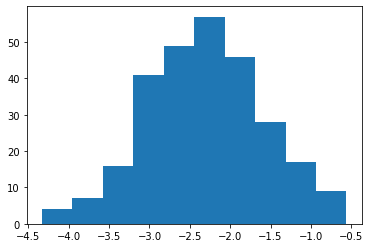

In [42]:
plt.hist(cluster1[1])

(array([ 5.,  9., 27., 56., 50., 53., 38., 27.,  7.,  4.]),
 array([-2.6972313 , -2.3356714 , -1.9741116 , -1.6125517 , -1.2509918 ,
        -0.88943195, -0.52787215, -0.16631226,  0.1952476 ,  0.55680746,
         0.9183673 ], dtype=float32),
 <BarContainer object of 10 artists>)

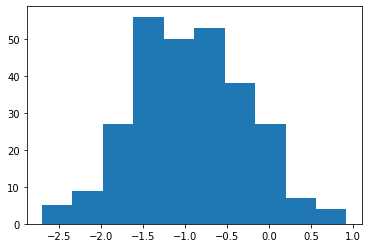

In [43]:
plt.hist(cluster2[1])

In [44]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=10):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=10):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

In [45]:
MA_coords = get_MA_coords(cluster1, 1, num_subj_threshold=14)
step = step = MA_coords[1]-MA_coords[0]

In [46]:
MA_coords

array([-3.65238028, -3.35065311, -3.04892595, -2.74719878, -2.44547161,
       -2.14374445, -1.84201728, -1.54029012, -1.23856295, -0.93683578])

In [47]:
step

0.3017271661758425

In [48]:
#SPAM_centers_c1 = [-2.05716]
#SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets_C1, cluster1, axis_n=1, FWHM=step)

Calculating moving averages:   0%|          | 0/10 [00:01<?, ?it/s]


KeyError: '152427'

In [ ]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.6, threshold="85%")
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)

In [ ]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster33.mesh")#### Saving of average crops

### Whole cluster analysis

In [49]:
clusters_centroids

array([[-2.3053873,  1.0942559],
       [-0.9350174,  2.3462682]], dtype=float32)

In [50]:
np.mean(clusters_centroids,axis=0)

array([-1.6202023,  1.720262 ], dtype=float32)

In [51]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")
centroid = np.mean(clusters_centroids, axis=0)
print(centroid)

central = closest_distance(centroid, dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster is {central}")
print(dstrb_sub[1][str(central)], dstrb_sub[2][str(central)])

cluster's centroids coordinates: 
 [[-2.3053873  1.0942559]
 [-0.9350174  2.3462682]]
[-1.6202023  1.720262 ]
Closest subject to centroid of cluster is 136833
-1.6381131 1.6645429


In [52]:
aligned_buckets, aligned_rot, aligned_transl = ma.align_buckets_by_ICP_batch(buckets, central)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 136833: 100%|██████████| 550/550 [00:05<00:00, 102.75it/s]


In [53]:
MA_coords = get_MA_coords(dstrb_sub, 1, num_subj_threshold=14)
step = step = MA_coords[1]-MA_coords[0]

In [54]:
MA_coords

array([-3.38633233, -3.01302504, -2.63971776, -2.26641047, -1.89310318,
       -1.51979589, -1.14648861, -0.77318132, -0.39987403, -0.02656675])

In [55]:
step

0.37330728742811425

In [56]:
len(dstrb_sub)

550

In [57]:
#SPAM_centers_c1 = [-2.05716]
#SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)
SPAM_vols, shift = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets, dstrb_sub, axis_n=1, FWHM=0.4)

Calculating moving averages: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


In [67]:
cld.draw(list(SPAM_vols.values())[-1], th_min=0.3)

In [68]:
cld.draw(list(SPAM_vols.values())[0], th_min=0.3)

In [104]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=1, threshold=0.45,deciReductionRate=0, smoothRate=0.25)
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=75)

100%|██████████| 10/10 [00:00<00:00, 34.01it/s]


In [105]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster44.mesh")#### Saving of average crops

100%|██████████| 10/10 [00:00<00:00, 69.68it/s]


In [106]:
fig = cld.draw(list(SPAM_vols.values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes.values())[0], fig=fig)

In [ ]:
SPAM_centers_c2 = [0]
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=1, FWHM=1)

In [ ]:
SPAM_meshes2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.8)
    
shifted_SPAM_meshes2 = {}
for dist, mesh in SPAM_meshes2.items():
    shifted_SPAM_meshes2[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

#### Visualization of average crops of both clusters

In [ ]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

In [ ]:

for x, mesh in tqdm(shifted_SPAM_meshes2.items()):
    aims.write(mesh, f"MA_{x}_2cluster2.mesh")

### 5) 2 clusters analysis

#### Loading of subjects of the two clusters

In [ ]:
tsne_subjects = pd.read_csv('tsne_asym_bench_sc.csv', index_col="id_sub").drop(columns={'Unnamed: 0'})
subjects_tsne = tsne_subjects.index
tsne_subjects = tsne_subjects.rename(columns={'tsne: 0': 0, 'tsne: 1': 1})
tsne_subjects.head()

We can use labels if we have them (in the case where we use benchmark subjects vs controls for example):

In [ ]:
color_dict = {'normal_test': 'blue', 'benchmark': 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)
for g in np.unique([tsne_subjects.label]):
    ix = np.where(tsne_subjects.label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'1st most important feature: {tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'2nd most important feature: {tsne_subjects.columns[1]}', fontsize=14)
plt.show()

We can also imagine a case where we don't have any labels but two clusters and apply a kmeans algorithm:

In [ ]:
from sklearn.cluster import KMeans

X = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

labels = kmeans.labels_
tsne_subjects['kmeans_label'] = labels
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

In [ ]:
color_dict = {1: 'blue', 0: 'magenta'}

arr = np.array([np.array([tsne_subjects[k][i] for k in tsne_subjects.columns[:2]]) for i in tsne_subjects.index])

fig, ax = plt.subplots()
ax = fig.add_subplot(111)

for g in np.unique(kmeans.labels_):
    ix = np.where(kmeans.labels_ == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g =='benchmark':
        g_lab = 'benchmark asymmetry'
    else:
        g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='crimson', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='navy', marker='X')
ax.scatter(tsne_subjects[0][116726], tsne_subjects[1][116726], color='forestgreen')
ax.scatter(tsne_subjects[0][163836], tsne_subjects[1][163836], color='forestgreen')


plt.xlabel(f'{tsne_subjects.columns[0]}', fontsize=14)
plt.ylabel(f'{tsne_subjects.columns[1]}', fontsize=14)
plt.show()

#### Central subjects for both clusters:

In [ ]:
central_1 = closest_distance(clusters_centroids[0], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], tsne_subjects.drop(['label', 'kmeans_label'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")

We create sub-dataframes based on labels

In [ ]:
cluster1 = tsne_subjects[tsne_subjects.kmeans_label==0]
cluster2 = tsne_subjects[tsne_subjects.kmeans_label==1]
assert(len(np.unique(list(cluster1.kmeans_label)))==1)
assert(len(np.unique(list(cluster2.kmeans_label)))==1)

#### Creation of buckets dictionnary

In [ ]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}

#### Alignement of the subjects to respective central subject

In [ ]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1, cores=2)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2, cores=2)

In [ ]:
sns.displot(cluster1, x=0)

In [ ]:
sns.displot(cluster2, x=0)

In [ ]:
SPAM_centers_c1 = [0]
SPAM_vols_c1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=0, FWHM=1)

In [ ]:
SPAM_centers_c2 = [4.5]
SPAM_vols_c2 = ma.calc_MA_volumes_batch(SPAM_centers_c2, aligned_buckets_C2, cluster2, axis_n=0, FWHM=1)

In [ ]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]+list(SPAM_vols_c2.items())[:]):
    SPAM_meshes[k]=cld.aims_tools.volume_to_mesh(
                    volume=volume, smoothingFactor=1.4,
                    aimsThreshold="90%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)]=cld.aims_tools.shift_aims_mesh(mesh, dist)

#### Visualization of average crops of both clusters

In [ ]:
fig = cld.draw(shifted_SPAM_meshes)
ma.plot.brochette_layout(fig, "subjects meshes")

#### Saving of average crops

In [ ]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster.mesh")